### Boiler plate

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report
from mriqa.tools import mean_im, diff_im, snr_im, snr
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings


### Series Index

In [2]:
def coil_element(dobj):
    return csa(dobj, 'image')['UsedChannelString'].index('X')

patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Signal_Combined': [27, 31],
    'Noise': [22, 24],
    'Noise_Combined': [23, 25],
    'Geometry': [28, 32]
}

### Geometry
For geometrical measures we want the combined and intensity corrected images.

[ 0.24414062  0.24414062]
516 505 274


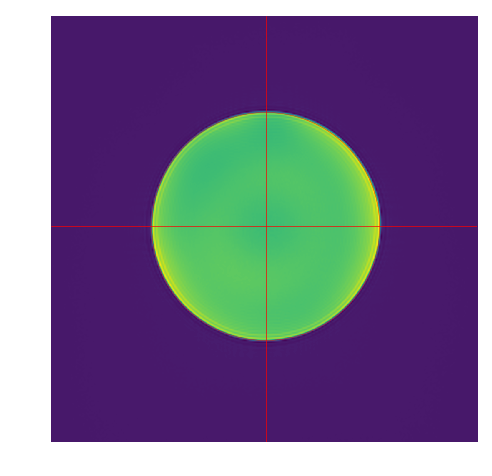

In [3]:
from scipy.ndimage import zoom

dobjs = fetch_series(patid, studyid, sernos=series['Geometry'])
ims = np.asarray([d.pixel_array for d in dobjs], dtype='float')
im = ims.sum(axis=0)

zoom_factor = 4.0
im = zoom(im, zoom_factor)

plt.imshow(im, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.grid(False)

# Centre phantom
pix_dims = np.asarray(dobjs[0].PixelSpacing) / zoom_factor
print(pix_dims)
expected_radius = SIEMENSLONGBOTTLE['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(im, expected_radius=expected_radius)
print(centre_x, centre_y, radius)
plt.axvline(centre_x, linewidth=0.5, color='red')
plt.axhline(centre_y, linewidth=0.5, color='red')

circle  = plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
plt.gcf().gca().add_artist(circle);

There's still something a little fishy about the centre.

Anyway, we want to take a series of profiles at diffferent angles around the centre and plot their length as a function of angle. If in addition we plot the difference between the distances from the centre to the edge we'll have a measure of any off centre, but the profile lengths should be pretty insensitive to this.

In [4]:
from scipy.ndimage import map_coordinates

def radial_profiles(image, centre, radius, ntheta=180, npoints=512, margin=1.25):
    """
    Sequence of radial profiles through the given centre over a range of angles.
    Image should already be interpolated up.
    """
    centre_x, centre_y =  centre

    # symmetrically about zero
    R = radius * margin
    theta = np.linspace(-np.pi/2, np.pi/2, ntheta)
    xas, yas = R * np.cos(theta), R * np.sin(theta)
    xbs, ybs = -xas, -yas

    # then add in offset to centre
    xas += centre_x
    xbs += centre_x
    yas += centre_y
    ybs += centre_y

    r = []
    dx = []
    dy = []
    x0 = []
    y0 = []
    for xa, xb, ya, yb in zip(xas, xbs, yas, ybs):
        x = np.linspace(xa, xb, npoints)
        y = np.linspace(ya, yb, npoints)
        r.append(map_coordinates(image, np.vstack((y, x))))
        x0.append(x[0])
        y0.append(y[0])
        dx.append(x[1] - x[0])
        dy.append(y[1] - y[0])

    return (
        np.array(r, dtype='float'),
        np.array(x0, dtype='float'),
        np.array(y0, dtype='float'),
        np.array(dx, dtype='float'),
        np.array(dy, dtype='float')
    )

In [5]:
def plot_profile_images(r):
    nprofiles, npoints = r.shape

    # derivatives of profiles
    dr = np.gradient(r, axis=-1)

    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    axs[0].imshow(r, cmap='viridis')
    axs[0].axis('off')
    axs[0].grid(False)

    axs[1].imshow(dr, cmap='coolwarm')
    axs[1].axis('off')
    axs[1].grid(False);

    axs[2].imshow(sdr, cmap='viridis')
    axs[2].axis('off')
    axs[2].grid(False)

    axs[3].imshow(ddr, cmap='coolwarm')
    axs[3].axis('off')
    axs[3].grid(False)

    fig.tight_layout()

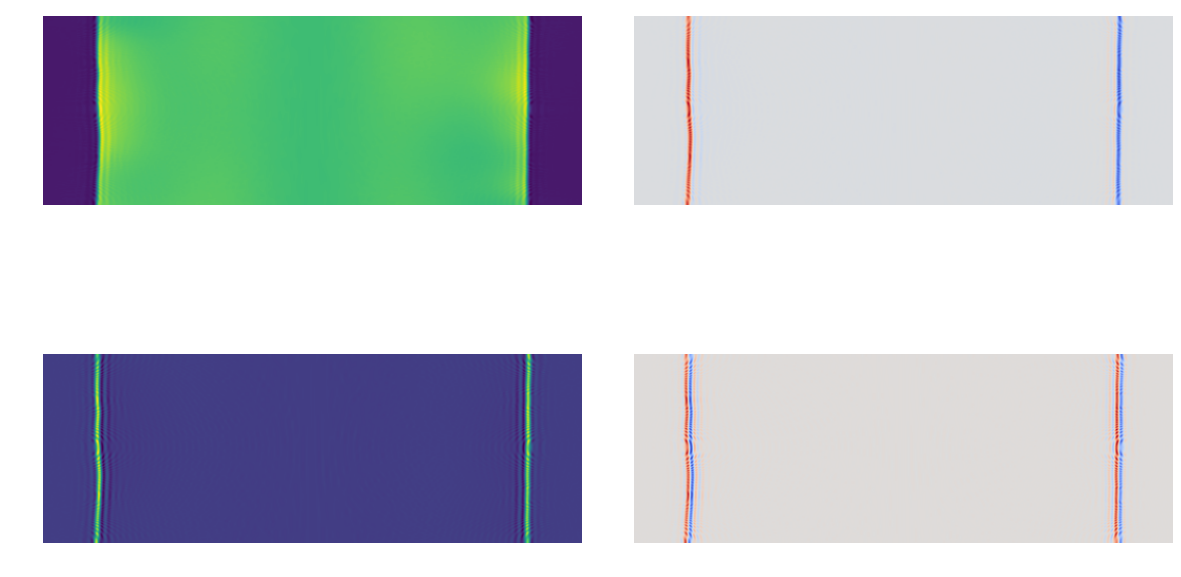

In [6]:
# We assume an isotropic image
assert pix_dims[0] == pix_dims[1]
plot_profile_images(radial_profiles(im, (centre_x, centre_y), radius)[0])

That does look a bit like there is an off-centre then. Let's plot all the edges over each other.

In [7]:
def plot_profiles_overlaid(r):
    nprofiles, npoints = r.shape
    # derivatives of profiles
    dr = np.gradient(r, axis=-1)
    
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
    axs = axs.ravel()

    l0, l1 = npoints//16, 3*npoints//16
    r0, r1 = 13*npoints//16, 15*npoints//16
    alpha = 5/nprofiles
    for profile in r:
        axs[0].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)

    axs[0].axis('tight')
    axs[0].set_title(r'$S(r)$')

    for profile in dr:
        axs[1].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[1].axis('tight');
    axs[1].set_title(r'$\mathrm{d}S / \mathrm{d}r$')

    for profile in sdr:
        axs[2].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[2].axis('tight');
    axs[2].set_title(r'Symmetric $\mathrm{d}S / \mathrm{d}r$')
    axs[2].set_xlabel('Index position')

    for profile in ddr:
        axs[3].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[3].axis('tight');
    axs[3].set_title(r'$\mathrm{d}^2S / \mathrm{d}r^2$')
    axs[3].set_xlabel('Index position')
 
    fig.tight_layout()

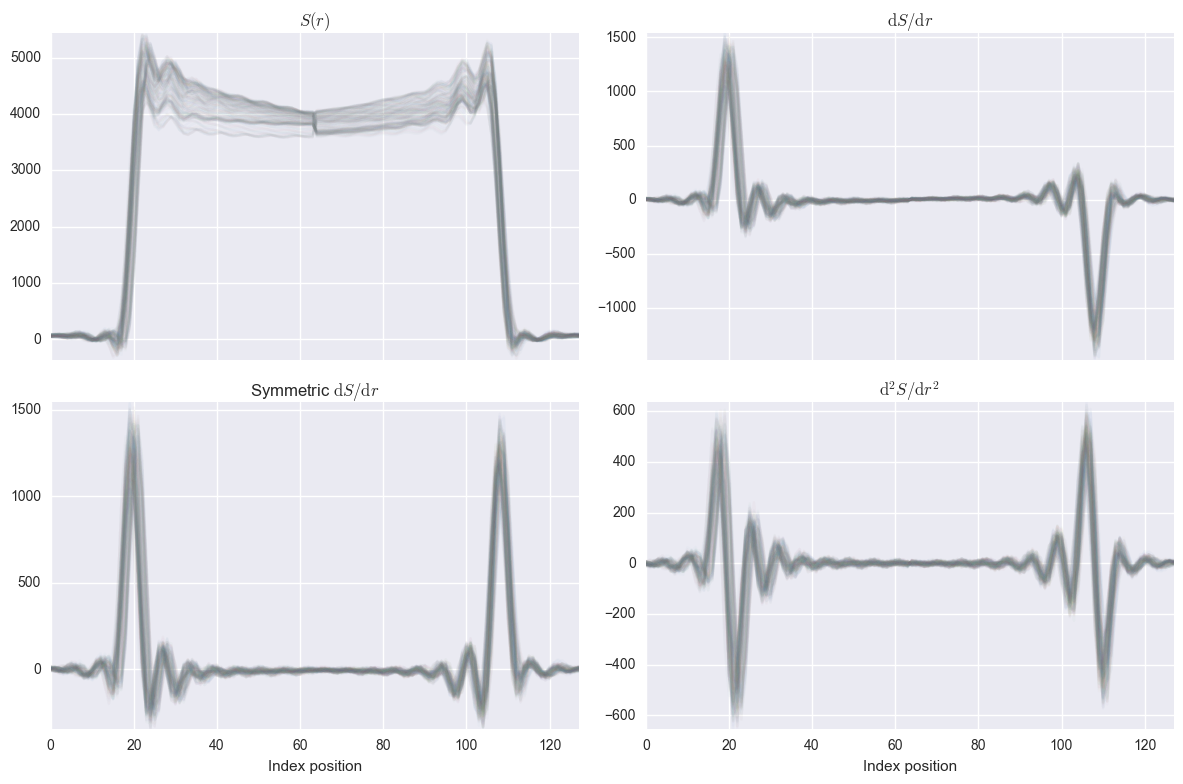

In [8]:
plot_profiles_overlaid(radial_profiles(im, (centre_x, centre_y), radius)[0])

Find the endpoints based on the magnitude of the derivative.

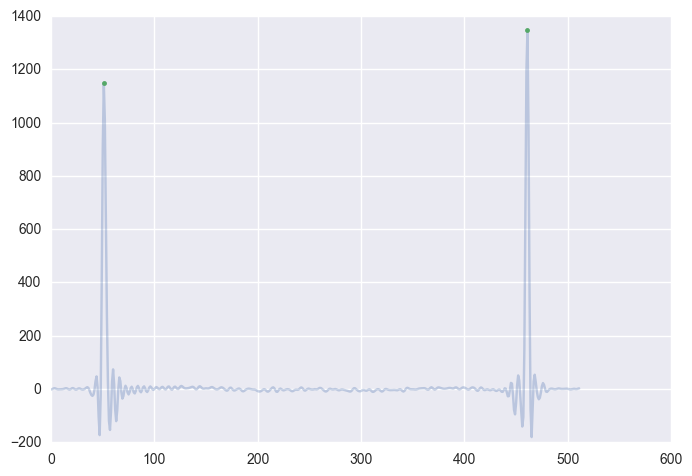

In [9]:
def positive_gradient(r):
    # flip sign of second edge to make both positive]
    nprofiles, npoints = r.shape
    dr = np.gradient(r, axis=-1)
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    dr[:, split:] *= -1 
    return dr

sdr = positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0])
split = sdr.shape[1] // 2
x0 = np.argmax(sdr[0][:split])
x1 = np.argmax(sdr[0][split:]) + split

plt.plot(sdr[0], '-', alpha=0.3)
plt.plot([x0, x1], [sdr[0][x0], sdr[0][x1]], '.');

Find all the endpoints and plot the length of the profile as a function of angle. 

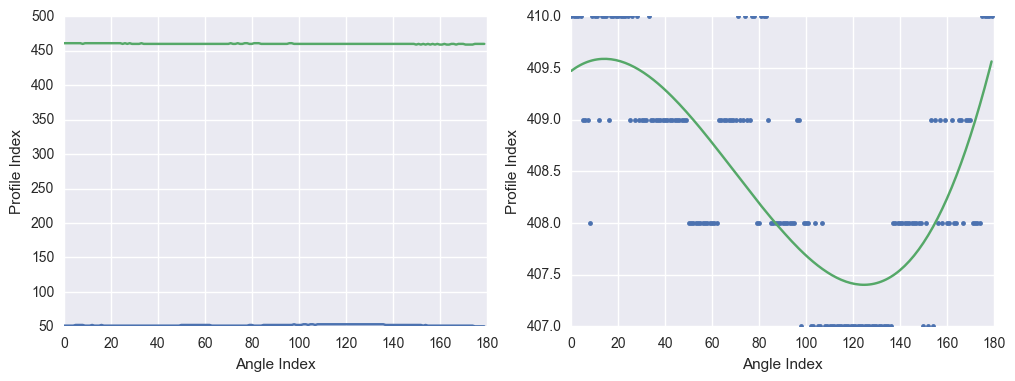

In [10]:
from scipy.signal import savgol_filter

x0_x1 = []
for line in positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0]):
    x0 = np.argmax(line[:split]) 
    x1 = np.argmax(line[split:]) + split
    x0_x1.append((x0, x1))
x0, x1 = np.array(x0_x1).T
dx = x1 - x0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x0)
axs[0].plot(x1)
axs[0].set_xlabel('Angle Index')
axs[0].set_ylabel('Profile Index')

axs[1].plot(dx, '.');
axs[1].plot(savgol_filter(dx, len(dx)-1, 3), '-')
axs[1].set_xlabel('Angle Index')
axs[1].set_ylabel('Profile Index');

We probably need to:
 - try and interpolate image up beforehand
 - check the interpolation that is being done by `map_coordinates`
 - see if we can do a more precise peak fit once we know approx maximum
 - consider using kde to get a smooth function
 - could look at sub pixel edge detection with derivative 

The `peakutils` package has a subpixel peak refinement routine `interpolate`.

In [14]:
import peakutils
x0_x1 = []
w = 10
result = radial_profiles(im, (centre_x, centre_y), radius)
print(len(result))
r, theta, dr = radial_profiles(im, (centre_x, centre_y), radius)
for line in positive_gradient(r):
    x0 = np.argmax(line[:split])
    window = line[x0-w:x0+w]
    x0 = peakutils.interpolate(range(2*w), window, [w])[0] + (x0 -w)

    x1 = np.argmax(line[split:]) + split
    window = line[x1-w:x1+w]
    x1 = peakutils.interpolate(range(2*w), window, [w])[0] + (x1 -w)

    x0_x1.append((x0, x1))

x0, x1 = np.array(x0_x1).T
dx = x1 - x0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.degrees(theta), x0*pix_dims[0])
axs[0].plot(np.degrees(theta), x1*pix_dims[0])
axs[0].set_xlabel(r'Angle $\theta^\circ$')
axs[0].set_ylabel(r'Profile Position (mm)')
axs[1].plot(np.degrees(theta), dx*pix_dims[0], '.');
axs[1].plot(np.degrees(theta), savgol_filter(dx, len(dx)-1, 3)*pix_dims[0], '-');
axs[1].set_xlabel(r'Angle $\theta^\circ$')
axs[1].set_ylabel(r'Profile Length (mm)');

5


ValueError: too many values to unpack

That seems bit better.

That looks like an erf based fit could work quite well, though there is some ringing.

Could optimise centre based on minimimising the variance of (midpoint - average midpoint) or more simply just the sum of the variances of the the edge positions. We can use the simple edge detector to speed up.

In [ ]:
from scipy.optimize import curve_fit
from warnings import warn
import peakutils
try:
    from functools import lru_cache
except ImportError:
    from backports.functools_lru_cache import lru_cache


def gaussian_fit(x, y):
    def gaussian(x, ampl, centre, stdev):
        return ampl * np.exp(-(x - float(centre)) ** 2 / (2.0 * stdev ** 2 + np.finfo(float).eps))
    
    if len(x) < 3:
        raise RuntimeError("At least 3 points required for Gaussian fitting")

    ampl_0, centre_0, stddev_0 = np.max(y), (x[0] + x[-1])/2, (x[1] - x[0]) * 2
    initial = [ampl_0, centre_0, stddev_0]
    lower_bounds = [0.75 * ampl_0, centre_0 - 2.0, stddev_0 / 4]
    upper_bounds = [1.25 * ampl_0, centre_0 + 2.0, 2 * stddev_0]
    
    try:
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.01, bounds=(lower_bounds, upper_bounds))
    except RuntimeError as e:
        # print(window, index)
        warn("gaussian_fit: fitting error [%s] (trying looser tolerance)" % e)
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.25, bounds=(lower_bounds, upper_bounds))
    return params[1]


def refine_peak(row, index, window_half_width=8):
    """
    Refine a peak position previously determined with argmax
    """
    if not (window_half_width <= index < len(row) + window_half_width, index):
        warn('peak too close to edge in refine_peak')
        return float(index)

    # centre window on previsously detected peak
    y = row[index-window_half_width:index+window_half_width]
    x = np.arange(len(y))
    
    # try and fit a gaussian
    try:
        return gaussian_fit(x, y) + index - window_half_width
    except RuntimeError as e:
        warn("refine_peak: %s" % e)
        return float(index)

    
def edge_positions(dr, split=None):
    """
    Positions of (exactly 2) peaks in derivative of projections.
    One before and one after "split"
    """
    nprofiles, npoints = dr.shape
    if split is None:
        split = npoints // 2
        
    edge_indices = np.argmax(dr[:, :split], axis=1)
    r0 = np.array([
        refine_peak(row, index)
        for row, index in zip(dr, edge_indices)
    ])
    
    edge_indices = np.argmax(dr[:, split:], axis=1) + split
    r1 = np.array([
        refine_peak(row, index)
        for row, index in zip(dr, edge_indices)
    ])

    return r0, r1


def centre_estimates(centre, radius, interpolated_image, npoints=256, nangles=23):
    """
    Estimates of the true centre based on distance alkong profiles to the phantom edges.
    """
    profiles, x0, y0, dx, dy  = radial_profiles(interpolated_image, centre, radius, npoints, nangles)
    dr = positive_gradient(profiles)
    r0, r1 = edge_positions(dr, split=dr.shape[1] // 2)
    profile_centre_offsets = (r0 + r1) / 2
    c_x, c_y = x0 + profile_centre_offsets * dx, y0 + profile_centre_offsets * dy
    return c_x, c_y

#def centre_estimate(centre, radius, interpolated_image, npoints=256, nangles=23):
#    c_x, c_y = centre_estimates(centre, radius, interpolated_image, npoints, nangles)
#    return c_x.mean(), c_y.mean()
    
def edge_map(centre, radius, interpolated_image, npoints=256, nangles=23):
    """
    Radial edge positions of circular phantom as function of angle about given centre.
    """
    dr = positive_gradient(radial_profiles(interpolated_image, centre, radius, npoints, nangles)[0])
    return edge_positions(dr, split=dr.shape[1] // 2)


def edge_bendiness(centre, radius, interpolated_image, npoints=256, nangles=23):
    """
    Objective function for optimizing centre
    """
    # rms of two pk-to-pk diffs
    # return np.var(r0) + np.var(r1)
    # not obvious what the obj fn should be here, but pk to pk seems to be better than variance
    # absolute dev is also a possibility
    r0, r1 = edge_map(centre, radius, interpolated_image, npoints, nangles)
    estimated_centres = (r1 + r0) / 2
    objfn_val = np.log(estimated_centres.var())
    return objfn_val

In [ ]:
import peakutils
x0_x1 = []
w = 10
for line in positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0]):
    x0 = refine_peak(line[:split], np.argmax(line[:split]))
    x1 = refine_peak(line[split:], np.argmax(line[split:])) + split
    x0_x1.append((x0, x1))

x0, x1 = np.array(x0_x1).T
dx = x1 - x0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.degrees(theta), x0*pix_dims[0])
axs[0].plot(np.degrees(theta), x1*pix_dims[0])
axs[0].set_xlabel(r'Angle $\theta^\circ$')
axs[0].set_ylabel(r'Profile Position (mm)')
axs[1].plot(np.degrees(theta), dx*pix_dims[0], '.');
axs[1].plot(np.degrees(theta), savgol_filter(dx, len(dx)-1, 3)*pix_dims[0], '-');
axs[1].set_xlabel(r'Angle $\theta^\circ$')
axs[1].set_ylabel(r'Profile Length (mm)');

Take a closer look at this peak finding

In [ ]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

dr = positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0])
nprofiles, npoints = dr.shape
split = npoints//2

drsub = dr[:, :split]
nprofiles, npoints = drsub.shape

peaks = np.argmax(drsub, axis=1)
refined_peaks = np.array([refine_peak(profile, peak) for profile, peak in zip(drsub, peaks)])

x1 = int(np.round(np.mean(peaks)))
lower, upper = x1 - 15, x1 + 15

fig, ax = plt.subplots()

i0 = len(drsub)//2
line, = ax.plot(drsub[i0, lower:upper], '-',  alpha=0.5)
line_p, = ax.plot([peaks[i0] - lower], [drsub[i0, int(peaks[i0])]], 'ro',  alpha=0.5)
line_rp, = ax.plot([refined_peaks[i0] - lower], [drsub[i0, int(refined_peaks[i0])]], 'go',  alpha=0.5)
ax.set_ylim(np.min(drsub), np.max(drsub))
plt.close(fig)

@interact
def plot_single_profile(index=(0, len(dr)-1)):
    line.set_ydata(drsub[index, lower: upper])
    line_p.set_ydata([drsub[index, int(peaks[index])]])
    line_p.set_xdata([peaks[index] - lower])

    line_rp.set_ydata([drsub[index, int(refined_peaks[index])]])
    line_rp.set_xdata([refined_peaks[index] - lower])

    fig.canvas.draw()
    display(fig)

In [ ]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

dr = positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0])
nprofiles, npoints = dr.shape
split = npoints//2

drsub = dr[:, split:]
nprofiles, npoints = drsub.shape

peaks = np.argmax(drsub, axis=1)
refined_peaks = np.array([refine_peak(profile, peak) for profile, peak in zip(drsub, peaks)])

x1 = int(np.round(np.mean(peaks)))
lower, upper = x1 - 15, x1 + 15

fig, ax = plt.subplots()

i0 = len(drsub)//2
line, = ax.plot(drsub[i0, lower:upper], '-',  alpha=0.5)
line_p, = ax.plot([peaks[i0] - lower], [drsub[i0, int(peaks[i0])]], 'ro',  alpha=0.5)
line_rp, = ax.plot([refined_peaks[i0] - lower], [drsub[i0, int(refined_peaks[i0])]], 'go',  alpha=0.5)
ax.set_ylim(np.min(drsub), np.max(drsub))
plt.close(fig)

@interact
def plot_single_profile(index=(0, len(dr)-1)):
    line.set_ydata(drsub[index, lower: upper])
    line_p.set_ydata([drsub[index, int(peaks[index])]])
    line_p.set_xdata([peaks[index] - lower])

    line_rp.set_ydata([drsub[index, int(refined_peaks[index])]])
    line_rp.set_xdata([refined_peaks[index] - lower])

    fig.canvas.draw()
    display(fig)

In [ ]:
new_centres = centre_estimates((centre_x, centre_y), radius, im)
plt.imshow(im, cmap='viridis', interpolation='nearest')
plt.grid(False)
plt.axis('off')
plt.scatter([centre_x], [centre_y], color='r')
print(new_centres[1].shape)
plt.scatter(new_centres[1], new_centres[0], color='y');

In [ ]:
new_centre

That looks like a manageable optimisation landcape - pretty much parabolic. It would be better though if we didn't have the up-front error in the centre so we could be sure that we are in the basin of the attractor for the initial guess.

The surface probably isn't very helpful when we get close to the profile pixel size though. We could do a second stage with a finer pixel size *or* the tweaked peak position estimation.

Also, we could do a least squares fit with (say) a 4th order polynomial and use the coefficients of that as the objective. Even better - model the effect of an offset in the centre (some sort of sinusoidal pattern) and fit that and use it's coefficients.

In [ ]:
from scipy.optimize import minimize

print('starting points = %f, %f' % (centre_x, centre_y))
opt_xx = [centre_x]
opt_yy = [centre_y]

def cb(params):
    #print('.', end='')
    opt_xx.append(params[0])
    opt_yy.append(params[1])
    
opts = minimize(
    edge_bendiness,
    np.array([centre_x, centre_y]),
    args=(radius, im),
    method='Nelder-Mead',
    callback=cb
)

cx_opt, cy_opt = opts.x
opt_xx, opt_yy = np.array(opt_xx), np.array(opt_yy)


print('final values = %f, %f' % (cx_opt, cy_opt))

This a bit weird. The Gaussian peak fitting is not converging, but it's difficult to see why. The peak is pretty well defined

In [ ]:
#ngrid = 40
ngrid = 20

hwin = 4
xpoints = np.linspace(centre_x-hwin, centre_x+hwin, ngrid)
ypoints = np.linspace(centre_y-hwin, centre_y+hwin, ngrid)

objsurf = np.zeros((ngrid, ngrid))
for ix, cx in enumerate(xpoints):
    for iy, cy in enumerate(ypoints):
        #print('.', end='')
        objsurf[iy, ix] = edge_bendiness((cx, cy), radius, im)

In [ ]:
xx, yy = np.meshgrid(xpoints, ypoints)

assert opt_xx.shape == opt_yy.shape

print(objsurf.shape)

fig, ax = plt.subplots(1, 1)
lines = ax.contourf(xx, yy, objsurf, rstride=1, cstride=1, cmap='viridis', linewidth=0)
ax.plot(opt_xx, opt_yy, ':.', color='firebrick')
fig.colorbar(lines);

In [ ]:
plt.imshow(objsurf, cmap='viridis', origin='lower');

In [ ]:
plot_profile_images(radial_profiles(im, (cx_opt, cy_opt), radius))

Still doesn't look quite ideal.

In [ ]:
plot_profiles_overlaid(radial_profiles(im, (cx_opt, cy_opt), radius))